In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import re
pd.set_option('display.max_colwidth', None)  # Show all text in each cell without truncation


In [115]:
# the directory containing all the data txt files
folder_path = 'hate-speech-dataset-master/all_files'
labels_df=pd.read_csv('hate-speech-dataset-master/annotations_metadata.csv')

In [116]:
labels_df

file_id  user_id  subforum_id  num_contexts   label
0      12834217_1   572066         1346             0  noHate
1      12834217_2   572066         1346             0  noHate
2      12834217_3   572066         1346             0  noHate
3      12834217_4   572066         1346             0    hate
4      12834217_5   572066         1346             0  noHate
...           ...      ...          ...           ...     ...
10939  33676864_5   734541         1388             0  noHate
10940  33677019_1   735154         1388             0  noHate
10941  33677019_2   735154         1388             0  noHate
10942  33677053_1   572266         1388             0    hate
10943  33677053_2   572266         1388             0  noHate

[10944 rows x 5 columns]

In [117]:
#creating master DataFrame
DF=pd.DataFrame(columns=['post','label', 'Comment_id'])


In [118]:
#iterrating through the files
for filename in os.listdir(folder_path):
    file_id_name=filename.replace(r'.txt','') #removing the .txt
    comment_id = re.search('(\d+?(?=\_))', file_id_name, re.IGNORECASE).group(1) # the comment ID using a lookahead (no _xx)


    with open(folder_path+'/'+filename,'r') as txt:
        content=txt.read()
        content = (lambda x: x.lower() if isinstance(x, str) else x)(content) #lowercase
        content = re.sub(r'\n', ' ', content)#removing \n newline
        content = re.sub(r'[^A-Za-z0-9\'\s]',' ',content) #removing special characters
        content = re.sub(r'[\']','',content) #removing special characters
        content = re.sub(r'( {2,100})',' ',content) #removing 2 or more spaces


    #label extraction
    label = labels_df[labels_df['file_id'] == file_id_name]['label'].values[0]


    #appending new row
    DF.loc[len(DF)]=[content,label,comment_id]
    

In [143]:
DF.groupby(DF['Comment_id']).count().sort_values(by='post',ascending=False).head(3)

post  label
Comment_id             
14098769      24     24
30659678      22     22
30571599      19     19

the longest comment has 24 sentences

In [120]:
DF.to_csv('hate-speech-dataset-master.csv')

------
# EDA: Basic Statistics:


In [145]:
DF.describe()

post   label Comment_id
count   10944   10944      10944
unique  10703       4       5000
top      2508  noHate   14098769
freq       21    9507         24

In [146]:
DF['label'].unique()

array(['noHate', 'idk/skip', 'relation', 'hate'], dtype=object)

In [192]:
DF.groupby(DF['label']).size()


label
hate        1196
idk/skip      73
noHate      9507
relation     168
dtype: int64

In [199]:
# Group by 'label' and count the occurrences of each label
label_counts = DF.groupby('label').size()

# Extract labels and counts
boxlabels = label_counts.index.tolist()
boxcounts = label_counts.tolist()
boxcounts

[1196, 73, 9507, 168]

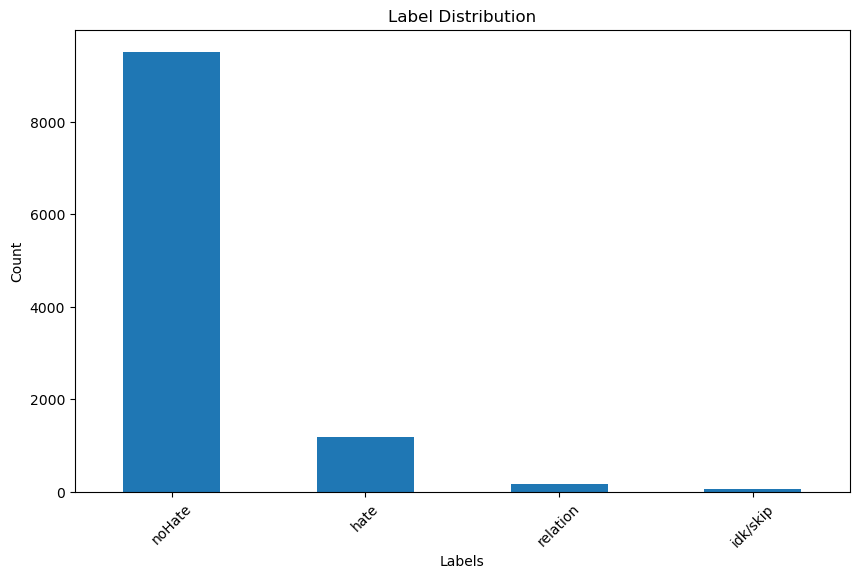

In [202]:
label_counts = DF['label'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.show()

In [225]:
DF[DF['label']=='idk/skip'].sample(5)

post  \
10739                                                                                                                                                                                                                                                       youtube broadcast yourself    
8408                                                                                                                                                       itt a legtobb kanadai anti rasszista aki meg nem az fel kimondani az erzelmeit mert ez sajnos a multikulturalizmus oraszaga    
1579                                                                                                                                                                                                                                                        youtube broadcast yourself    
5229   https www stormfront org forum t384418 https www stormfront org forum t291185 https www stormfront org forum t113191 https www stormfront org forum t46864 https www stormfront org forum t101175 https www stormfront org forum t118865 https www stormfront org forum t142566    
9842                                                                                                                                                                                                                                                        youtube broadcast yourself    

          label Comment_id  
10739  idk/skip   30395748  
8408   idk/skip   12845244  
1579   idk/skip   30395748  
5229   idk/skip   14084809  
9842   idk/skip   30395748

In [ ]:
# adding "youtube yourself" into the hate column due it being a reference to suicide.
DF.loc[DF['post'].str.contains('youtube broadcast yourself'),'label']='hate'

## Enhancing the dataset: improving the labels using outside hatespeech data
------
#### inital keywords test:

In [241]:
#hate speech keywords from https://www.kaggle.com/datasets/victorcallejasf/multimodal-hate-speech?select=hatespeech_keywords.txt
Hate_speech_keywords=['asian','drive','feminazi','sjw',
'WomenAgainstFeminism','blameonenotall','islam','terrorism','notallmen',
'victimcard','card','arab','terror','gamergate','jsil','racecard',
'race','card','refugeesnotwelcome','DeportallMuslims','banislam','banmuslims',
'destroyislam','norefugees','nomuslims','border','jumper','border','shyne','boojie',
'surrender','monkey','chinaman','hillbilly','whigger','white','shine','wigger','wigerette',
'bitter','clinger','conspiracy','theorist','redneck','rube','trailer','park','trash','trailer',
'trash','white','trash','yobbo','retard','retarded','spook','white','trash','trailer','trash',
'coonass','trailer','park','trash','raghead','house','coal','white','nigger','camel','fucker',
'moon','cricket','wetback','spic','bint','dyke','twat','bamboo','coon','camel','fucker','chinaman',
'limey','plastic','paddy','sideways','pussy','surrender','monkey','whigger','white','nigger','wigger',
'zionazi','camel','fucker','muzzie','soup','taker','zionazi','dyke','faggot','#DontDateSJWs','#Feminazi',
'#FemiNazi','BuildTheWall','#sorryladies','#IWouldFuckYouBut',
'Deport Them ALL','RefugeesNOTwelcome','#BanSharia','#BanIslam','#nosexist','cunt','nigga']







In [242]:
#checking if the keywords are in the dtataset and labeled incorrectly:
pattern = '|'.join(map(re.escape, Hate_speech_keywords))

DF[(DF['post'].str.contains(pattern)) & (DF['label'] == 'noHate')]


post  \
11     always speak out when in a class with a brainwashing teacher because once you speak others who may feel the same way may realize they are not alone but if you say nothing then everybody will without question go along with the anti white brainwashing    
21                                                                                                                               the sooner we acknowledge eachother in local areas and band together as a unit the sooner we become a strong white nation again    
37                                                                                                                            any europeans traveling to this country must be insane i hope any whites traveling there stay safe and use good judgement at night    
76                                                                                                                 in the old days private security and armed whites would take care of this but maybe the negros are fighting smarter by taking on soft targets    
81                                                                                                                                          unfortunately intelligent outliers of races generally not gifted with a high average intelligence can be very deadly    
...                                                                                                                                                                                                                                                           ...   
10891                                                                                                   we knew that these structures were built by sub saharan blacks in the same way we knew that the civilization greek and romanian built by white europeans    
10896                                                                                                                                                                                           white person before hurrying to catch the ttc out of scarborough    
10904                                                                       i base this post on the fact that i live a few hundred yards from the house i was born in and have never felt the desire to suck the milk from anything other than an english nipple    
10906                                                                                                                                                                           i guess whites will either have to start fighting back or be slowly exterminated    
10930                                                                                                                                                        with the exception of two mestizo teachers all my teachers from kindergarten to now have been white    

        label Comment_id  
11     noHate   30586609  
21     noHate   14035837  
37     noHate   13379474  
76     noHate   30390371  
81     noHate   14677489  
...       ...        ...  
10891  noHate   14672822  
10896  noHate   14022819  
10904  noHate   14025960  
10906  noHate   12868154  
10930  noHate   30709706  

[1425 rows x 3 columns]

as we can see, an extra 1425 rows can no be added to the hate section

In [243]:
#adding 1425 rows to hate label
DF.loc[(DF['post'].str.contains(pattern)) & (DF['label'] == 'noHate'),'label']='hate'


In [ ]:
#https://www.kaggle.com/datasets/pettertornberg/stormfront

In [262]:
#Using ngrams for a second refinement of the labels:
DF_ngram=pd.read_csv('refined_ngram_dict.csv')
DF_ngram=DF_ngram.drop(columns=['prophate'])

In [264]:
DF_ngram_str=' | '.join(DF_ngram['ngram'])

In [266]:
DF[(DF['post'].str.contains(DF_ngram_str)) & (DF['label'] == 'noHate')]


post  \
262                                 youtube x202a police brutality in jamaica caught on tape disturbing footage of police killing man cold blooded terribel x202c rlm it s just the way blacks react    
326                                                                                                              wait until the blacks hear about black douglas or the black watch or black thursday    
354                                                                                                                               there are plenty of blacks in catholic schools or were in our area    
357                                                                                                the 19 year old had beaten two elderly long beach women to death and raped one with a wine bottle    
395                                                               i blame the school with all it s ethicts and multicult loving teachers i m saving as many pupils i can but i fear that s not enught   
...                                                                                                                                                                                               ...   
9803                                          ive talked to lots of punks about it and i get the same response from them that i get from blacks and minorities i want to hear a more educated opinion   
9943   well i could give you another word for the female version of that part of the anatomy it begins with a c ends with a t and has the letters un in between but the language filters wo nt let me   
10033                                                                                                                                  what i meant was blacks are the oldest living humans on earth    
10136                                                                                                                                                         youtube black savages bake puppy alive    
10770                                                                            last i checked though there are more europeans being raped by non europeans in europe than there have been in canada   

        label Comment_id  
262    noHate   13457207  
326    noHate   14673502  
354    noHate   30537360  
357    noHate   13507823  
395    noHate   13610403  
...       ...        ...  
9803   noHate   31761747  
9943   noHate   13477287  
10033  noHate   31750807  
10136  noHate   13461530  
10770  noHate   13946975  

[71 rows x 3 columns]

as we can see there are an extra 75 rows mislabeled


In [267]:
DF.loc[(DF['post'].str.contains(DF_ngram_str)) & (DF['label'] == 'noHate'),'label']='hate'


In [283]:
DF.loc[(DF['label']=='noHate') & (DF['post'].str.contains('jews')),'label']='hate'

In [290]:
DF.loc[(DF['label']=='noHate') & (DF['post'].str.contains('fag')),'label']='hate'

In [415]:
DF.loc[(DF['label']=='noHate') & (DF['post'].str.contains('nazi ')),'label']='hate'

In [329]:
DF.loc[(DF['label']=='noHate') & (DF['post'].str.contains('aryan')),'label']='hate'

In [411]:
DF.loc[(DF['label']=='noHate') & (DF['post'].str.contains('14')),'label']='hate' #14 is a dogwhistle

In [377]:
#more dog whistles
dog_whistles="""(?i)
88| \sH\s| 14| 2083| 9%| 1488| 6| 311| KKK| 5| 23| 28| B&H| Blood| 
Honour| BM| C18| Combat| BNSM| ITP| Third| KKK| N9S| 9th| ZOG| NSM|
Socialist| Movement| RVF| BFG| Bound| Glory| FFF| JOG| Occupied| KIGY
| LOSG| League| NS| ORION| Race| Nation| RAC| RAHOWA| Racial| Holy War|
WPWW| SWP| Supreme| White| Power
blood libel |cabal |clannish |conspiracy |theory 
|cosmopolitan |elite |cowardice |creatures |loyalty |(((echo)))|globalist |Goyim|greed |Holocough |Holocaust |Illuminati
 |capitalist  |communist |Jew down |Jewish figures |Jewish |
lightning |Jewish  |Judas |silver |Khazars |kosher |New World order|Jews |poisoning |Protocols|Zion |QAnon |Rothschild |
Satan |scapegoat |silencing |slavery |slave |trade |smirking |merchant |Soros |Zionism 
|racism |Zio |Zionist |Occupied |reich
"""

In [379]:
DF.loc[(DF['post'].str.contains(dog_whistles)) & (DF['label'] == 'noHate'),'label']='hate'


/var/folders/1x/qzsml84s3_91xx343khzjmhw0000gn/T/ipykernel_34032/794850983.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  DF.loc[(DF['post'].str.contains(dog_whistles)) & (DF['label'] == 'noHate'),'label']='hate'


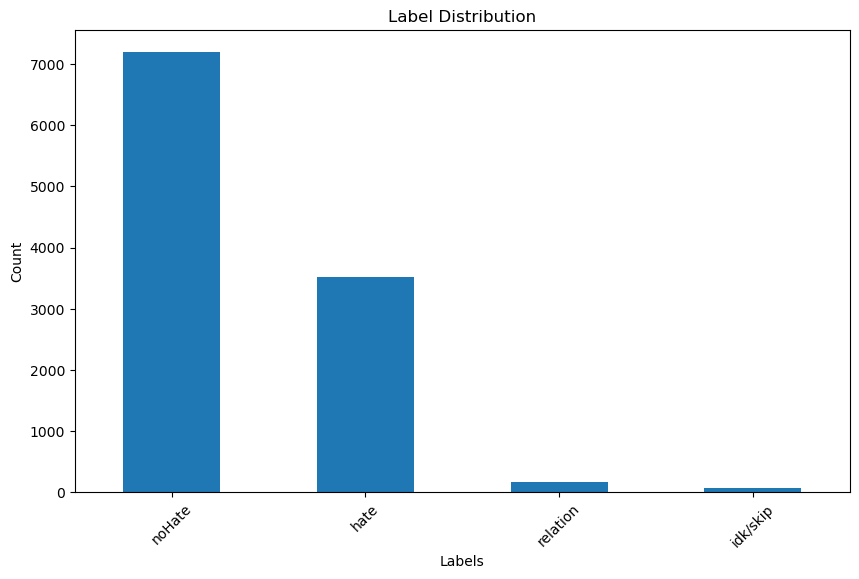

In [380]:
label_counts = DF['label'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.show()

### Cleaning The data:

In [430]:
#removing short posts: less than 3 words
DF['wordcount']=DF['post'].apply(lambda x: len(str.split(x)))
DF

post  \
0                                                                                                                it s like that at most public boards    
1                                                                   i wonder if one of the victims opened the door to their apartment for some reason    
2      some people believe the jack o lantern also represents the ancient celtic warrior s tradition of taking the heads of their enemies as trophies    
3                                                                                                                                            ready go    
4                                                                                                                                              thanks    
...                                                                                                                                                ...   
10939                                                                             also it s so sad to see so much pre made crap in their grocery buys    
10940                                                                                                                                               cf   
10941                                                                                                                     sorry that you were unaware    
10942                                                                                                                     my grandmother has red hair    
10943                        when anyone is ready we are now taking reservations on lots as we speak first come first served contact me for more info    

        label Comment_id  wordcount  
0      noHate   13458115          8  
1      noHate   13367480         16  
2      noHate   30422449         24  
3      noHate   14651837          2  
4      noHate   30527903          1  
...       ...        ...        ...  
10939  noHate   13472256         16  
10940  noHate   14417873          1  
10941  noHate   30597853          5  
10942  noHate   30626265          5  
10943  noHate   14268621         23  

[10944 rows x 4 columns]

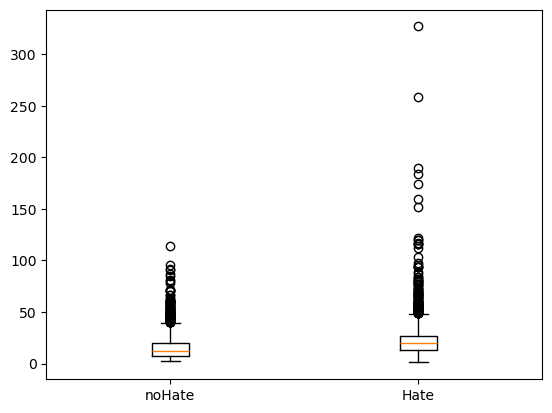

In [464]:
plt.boxplot([DF[DF['label']=='noHate']['wordcount'],DF[DF['label']=='hate']['wordcount']],labels=['noHate','Hate'])
plt.show()

In [463]:
#dropping all rows less than 3 words
DF = DF.drop(DF.loc[(DF['wordcount'] <= 1) & (DF['label'] == 'noHate')].index)


In [469]:
import spacy 
nlp=spacy.load('en_core_web_md')#using the md model because it has word embeddings



In [470]:
#loading our dataframe into the spacy doc object

def docFeeder(text):
    doc=nlp(text)
    #inb4 process..

    return doc

docs=[]#spacy doc object of same len as our dataset. containing the text=>doc object of each row
for text in DF['post']:
    doc=docFeeder(text)
    docs.append(doc)
    


In [ ]:
#index reset to match doc 
DF=DF.reset_index(drop=True)


In [488]:
DF.sample(5)

post  \
528                                                                                                                                                            prince of bel air moeisha etc    
5529                            you picked a poor time to start such a thread seeing as how just this week the ira were categorically cleared of all paramilitary terrorist illegal activity    
6775                                                                                                                                  keep your eyes open at all times for fallen powerlines    
7924  emily tubb 33 of southaven who is in the english department at east high school was indicted last week for alleged possession with intent to distribute adderall alprazolam and heroin    
5084                                                                                                                                                         is that sign like passop danger    

       label Comment_id  wordcount  
528   noHate   12959694          6  
5529    hate   13860252         27  
6775  noHate   30395929         10  
7924  noHate   13125529         30  
5084  noHate   14097593          6

In [491]:
for token in docs[5084]:
    print(token.lemma_)
    

be
that
sign
like
passop
danger


#### removing stopwords:

In [494]:
DF_copy=DF.copy()

In [495]:
# creating a new row of lemmatized/non stop word posts
row_lemma_stop=[]
for i in range(len(docs)):
    lemmatized_tokens = []

    for token in docs[i]:
        if not token.is_stop:
            lemmatized_tokens.append(token.lemma_)
    row_lemma_stop.append(' '.join(lemmatized_tokens))

row_lemma_stop[0]

's like public board'

In [503]:
DF['Normalized']=row_lemma_stop

In [504]:
DF

post  \
0                                                                                                                it s like that at most public boards    
1                                                                   i wonder if one of the victims opened the door to their apartment for some reason    
2      some people believe the jack o lantern also represents the ancient celtic warrior s tradition of taking the heads of their enemies as trophies    
3                                                                                                                                            ready go    
4                                                                               com watch v krdycxpb4fs and then the entire myron fagan video youtube    
...                                                                                                                                                ...   
10598                                             i hardly have any slav in me but my great great grandma was serbian so i have a little slavic in me    
10599                                                                             also it s so sad to see so much pre made crap in their grocery buys    
10600                                                                                                                     sorry that you were unaware    
10601                                                                                                                     my grandmother has red hair    
10602                        when anyone is ready we are now taking reservations on lots as we speak first come first served contact me for more info    

        label Comment_id  wordcount  \
0      noHate   13458115          8   
1      noHate   13367480         16   
2      noHate   30422449         24   
3      noHate   14651837          2   
4        hate   12870229         12   
...       ...        ...        ...   
10598  noHate   30542001         22   
10599  noHate   13472256         16   
10600  noHate   30597853          5   
10601  noHate   30626265          5   
10602  noHate   14268621         23   

                                                                                              Normalized  
0                                                                                    s like public board  
1                                                               wonder victim open door apartment reason  
2      people believe jack o lantern represent ancient celtic warrior s tradition take head enemy trophy  
3                                                                                                  ready  
4                                               com watch v krdycxpb4fs entire myron fagan video youtube  
...                                                                                                  ...  
10598                                              hardly slav great great grandma serbian little slavic  
10599                                                                         s sad pre crap grocery buy  
10600                                                                                      sorry unaware  
10601                                                                               grandmother red hair  
10602                                           ready take reservation lot speak come serve contact info  

[10603 rows x 5 columns]

In [508]:
DF['Normalized']=DF['Normalized'].replace('(\b\w\b)','',regex=True) 
DF['Normalized']=DF['Normalized'].replace('  ',' ',regex=True) 
DF

post  \
0                                                                                                                it s like that at most public boards    
1                                                                   i wonder if one of the victims opened the door to their apartment for some reason    
2      some people believe the jack o lantern also represents the ancient celtic warrior s tradition of taking the heads of their enemies as trophies    
3                                                                                                                                            ready go    
4                                                                               com watch v krdycxpb4fs and then the entire myron fagan video youtube    
...                                                                                                                                                ...   
10598                                             i hardly have any slav in me but my great great grandma was serbian so i have a little slavic in me    
10599                                                                             also it s so sad to see so much pre made crap in their grocery buys    
10600                                                                                                                     sorry that you were unaware    
10601                                                                                                                     my grandmother has red hair    
10602                        when anyone is ready we are now taking reservations on lots as we speak first come first served contact me for more info    

        label Comment_id  wordcount  \
0      noHate   13458115          8   
1      noHate   13367480         16   
2      noHate   30422449         24   
3      noHate   14651837          2   
4        hate   12870229         12   
...       ...        ...        ...   
10598  noHate   30542001         22   
10599  noHate   13472256         16   
10600  noHate   30597853          5   
10601  noHate   30626265          5   
10602  noHate   14268621         23   

                                                                                          Normalized  
0                                                                                  like public board  
1                                                           wonder victim open door apartment reason  
2      people believe jack lantern represent ancient celtic warrior tradition take head enemy trophy  
3                                                                                              ready  
4                                             com watch krdycxpb4fs entire myron fagan video youtube  
...                                                                                              ...  
10598                                          hardly slav great great grandma serbian little slavic  
10599                                                                       sad pre crap grocery buy  
10600                                                                                  sorry unaware  
10601                                                                           grandmother red hair  
10602                                       ready take reservation lot speak come serve contact info  

[10603 rows x 5 columns]

## WordCloud:

In [122]:
from wordcloud import WordCloud

In [420]:
text_datahate=' '.join(DF[DF['label']=='hate']['post'])
text_datanohate=' '.join(DF[DF['label']=='noHate']['post'])

In [141]:
#word counts for each category:

hateWordCount=len(str.split(text_datahate))
No_hateWordCount=len(str.split(text_datanohate))

print('Hate posts word count: ',hateWordCount)
print('NoHate posts word count: ',No_hateWordCount)


Hate posts word count:  26661
NoHate posts word count:  150685


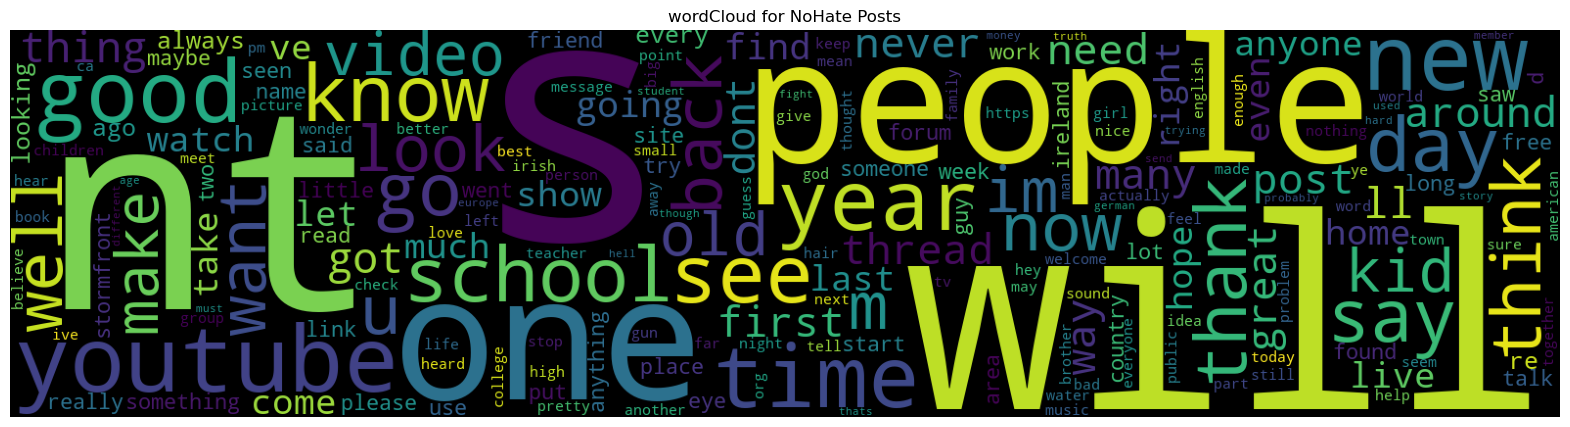

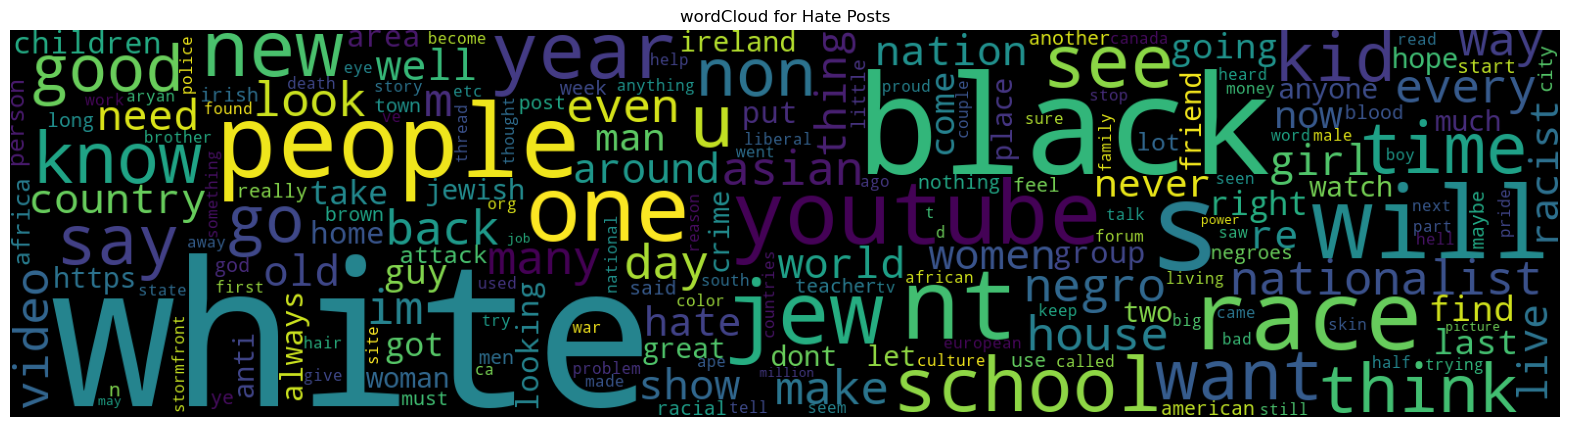

In [421]:
wordcloud = WordCloud(collocations=False,width=1584, height=396, background_color='Black').generate(text_datanohate)

# Display the word cloud

plt.figure(figsize=(20, 10))
plt.title('wordCloud for NoHate Posts')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('wordcloudNoHate.png', facecolor='k', bbox_inches='tight')


wordcloud = WordCloud(collocations=False,width=1584, height=396, background_color='Black').generate(text_datahate)

# Display the word cloud

plt.figure(figsize=(20, 10))
plt.title('wordCloud for Hate Posts')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('wordcloudNoHate.png', facecolor='k', bbox_inches='tight')



### WordCloud for Normalized text

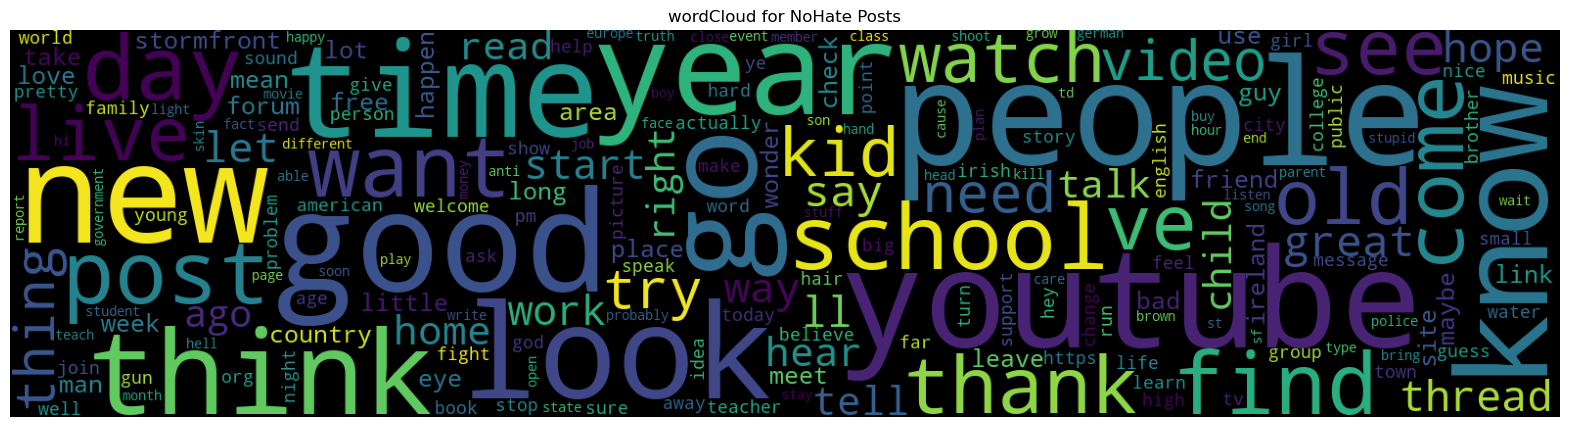

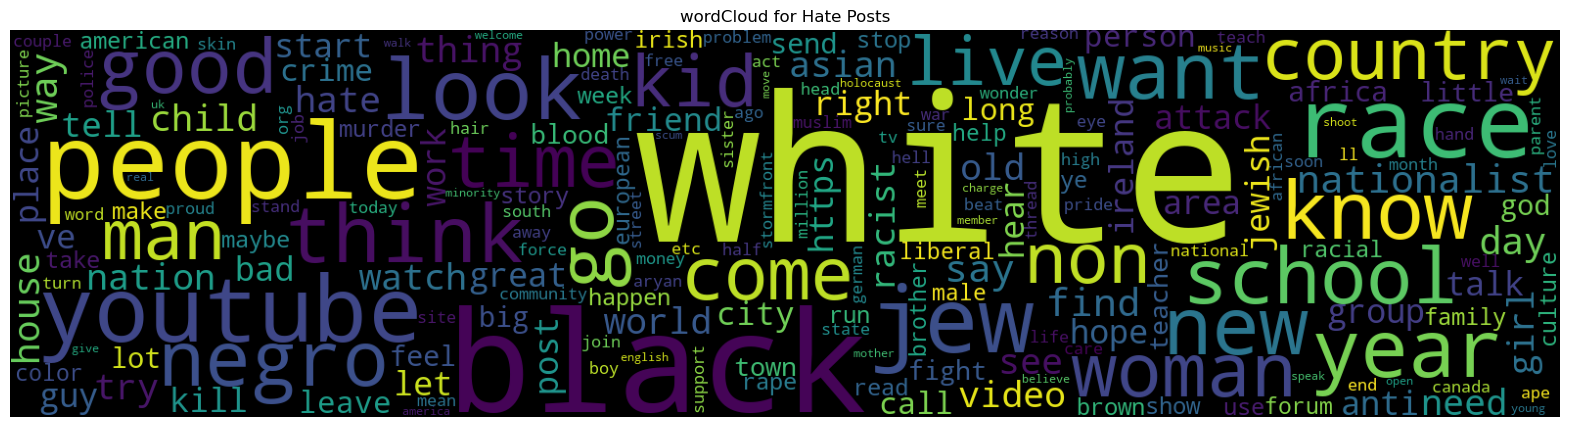

In [509]:
text_datahate=' '.join(DF[DF['label']=='hate']['Normalized'])
text_datanohate=' '.join(DF[DF['label']=='noHate']['Normalized'])
wordcloud = WordCloud(collocations=False,width=1584, height=396, background_color='Black').generate(text_datanohate)

# Display the word cloud

plt.figure(figsize=(20, 10))
plt.title('wordCloud for NoHate Posts')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('wordcloudNoHate_norm.png', facecolor='k', bbox_inches='tight')


wordcloud = WordCloud(collocations=False,width=1584, height=396, background_color='Black').generate(text_datahate)

# Display the word cloud

plt.figure(figsize=(20, 10))
plt.title('wordCloud for Hate Posts')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.imshow(wordcloud)
plt.savefig('wordcloudNoHate_norm.png', facecolor='k', bbox_inches='tight')



### BoxPlot for Normalized Text

In [ ]:
DF['wordcount_norm']=DF['Normalized'].apply(lambda x: len(str.split(x)))



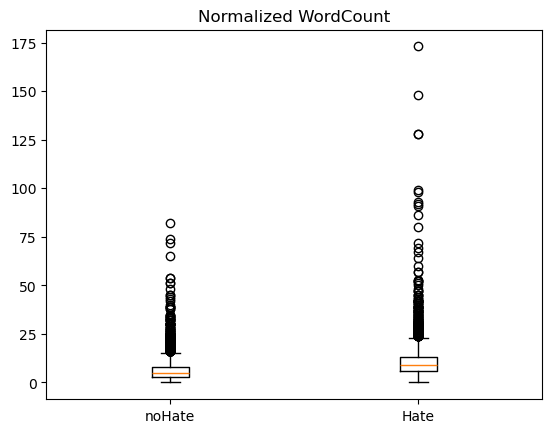

In [514]:
plt.boxplot([DF[DF['label']=='noHate']['wordcount_norm'],DF[DF['label']=='hate']['wordcount_norm']],labels=['noHate','Hate'])
plt.title('Normalized WordCount')
plt.show()

In [515]:
DF.to_csv('EDA_normed.csv')

In [576]:
DF_parquet=DF[['Normalized','label']]
DF_parquet=DF_parquet[(DF_parquet['label']=='noHate')| (DF_parquet['label']=='hate')]

In [577]:
DF_parquet

Normalized  \
0                                                                                  like public board   
1                                                           wonder victim open door apartment reason   
2      people believe jack lantern represent ancient celtic warrior tradition take head enemy trophy   
3                                                                                              ready   
4                                             com watch krdycxpb4fs entire myron fagan video youtube   
...                                                                                              ...   
10598                                          hardly slav great great grandma serbian little slavic   
10599                                                                       sad pre crap grocery buy   
10600                                                                                  sorry unaware   
10601                                                                           grandmother red hair   
10602                                       ready take reservation lot speak come serve contact info   

        label  
0      noHate  
1      noHate  
2      noHate  
3      noHate  
4        hate  
...       ...  
10598  noHate  
10599  noHate  
10600  noHate  
10601  noHate  
10602  noHate  

[10376 rows x 2 columns]

In [578]:
DF_parquet.loc[:, 'label'] = DF_parquet['label'].map({"noHate": int(0), "hate": int(1)})

### hate=>1  noHate=>0

In [579]:
DF_parquet

Normalized  \
0                                                                                  like public board   
1                                                           wonder victim open door apartment reason   
2      people believe jack lantern represent ancient celtic warrior tradition take head enemy trophy   
3                                                                                              ready   
4                                             com watch krdycxpb4fs entire myron fagan video youtube   
...                                                                                              ...   
10598                                          hardly slav great great grandma serbian little slavic   
10599                                                                       sad pre crap grocery buy   
10600                                                                                  sorry unaware   
10601                                                                           grandmother red hair   
10602                                       ready take reservation lot speak come serve contact info   

      label  
0         0  
1         0  
2         0  
3         0  
4         1  
...     ...  
10598     0  
10599     0  
10600     0  
10601     0  
10602     0  

[10376 rows x 2 columns]

In [668]:
DF_parquet.to_parquet('DF_norm.parquet', engine='fastparquet')


In [669]:
DF_parquet.to_csv('DF_norm.csv')


# ngram analysis  + TFIDF Tokenization

In [657]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import shuffle
from collections import Counter
import joblib



In [655]:
Questions=DF_parquet['Normalized']
Labels=DF_parquet['label']

In [656]:
#Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,4),
                                #min_df=5,
                                #max_df=0.2,
                                token_pattern=r"\b[^0-9\s]{3,}\b"
                                #sublinear_tf=True
) #ngram considered

#Fit and transform the corpus to generate the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(Questions)

# Step 3: Convert the TF-IDF matrix to a DataFrame for better visualization
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df_tfidf

aangirfan  aangirfan blogspot  aangirfan blogspot com  \
0            0.0                 0.0                     0.0   
1            0.0                 0.0                     0.0   
2            0.0                 0.0                     0.0   
3            0.0                 0.0                     0.0   
4            0.0                 0.0                     0.0   
...          ...                 ...                     ...   
10371        0.0                 0.0                     0.0   
10372        0.0                 0.0                     0.0   
10373        0.0                 0.0                     0.0   
10374        0.0                 0.0                     0.0   
10375        0.0                 0.0                     0.0   

       aangirfan blogspot com ual  abandon  abandon child  abandon god  \
0                             0.0      0.0            0.0          0.0   
1                             0.0      0.0            0.0          0.0   
2                             0.0      0.0            0.0          0.0   
3                             0.0      0.0            0.0          0.0   
4                             0.0      0.0            0.0          0.0   
...                           ...      ...            ...          ...   
10371                         0.0      0.0            0.0          0.0   
10372                         0.0      0.0            0.0          0.0   
10373                         0.0      0.0            0.0          0.0   
10374                         0.0      0.0            0.0          0.0   
10375                         0.0      0.0            0.0          0.0   

       abandon god offer  abandon god offer wealth  abandon hospital  ...  \
0                    0.0                       0.0               0.0  ...   
1                    0.0                       0.0               0.0  ...   
2                    0.0                       0.0               0.0  ...   
3                    0.0                       0.0               0.0  ...   
4                    0.0                       0.0               0.0  ...   
...                  ...                       ...               ...  ...   
10371                0.0                       0.0               0.0  ...   
10372                0.0                       0.0               0.0  ...   
10373                0.0                       0.0               0.0  ...   
10374                0.0                       0.0               0.0  ...   
10375                0.0                       0.0               0.0  ...   

       zwei zwilling paare kommen  zwilling  zwilling paare  \
0                             0.0       0.0             0.0   
1                             0.0       0.0             0.0   
2                             0.0       0.0             0.0   
3                             0.0       0.0             0.0   
4                             0.0       0.0             0.0   
...                           ...       ...             ...   
10371                         0.0       0.0             0.0   
10372                         0.0       0.0             0.0   
10373                         0.0       0.0             0.0   
10374                         0.0       0.0             0.0   
10375                         0.0       0.0             0.0   

       zwilling paare kommen  zwilling paare kommen munter  zyklon  \
0                        0.0                           0.0     0.0   
1                        0.0                           0.0     0.0   
2                        0.0                           0.0     0.0   
3                        0.0                           0.0     0.0   
4                        0.0                           0.0     0.0   
...                      ...                           ...     ...   
10371                    0.0                           0.0     0.0   
10372                    0.0                           0.0     0.0   
10373                    0.0         

In [658]:

joblib.dump(tfidf_vectorizer, 'tfidfvectorizer.pkl')


['tfidfvectorizer.pkl']

--------
### initial classification model to sanity check the tokenization process:


In [659]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [660]:
# feature/response splits
X_train, X_test, Y_train, Y_test = train_test_split(df_tfidf, Labels, test_size=0.2, random_state=42)


array([0, 1], dtype=object)

In [661]:
#SVM
import sklearn
from sklearn.svm import LinearSVC
import spacy
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


In [665]:
%%time

#using SVM for high dimensional set
model_Svm=LinearSVC()
model_Svm.fit(X_train,Y_train.astype('int'))

CPU times: user 22.7 s, sys: 21.6 s, total: 44.3 s
Wall time: 1min 21s


LinearSVC()

In [667]:
y_pred=model_Svm.predict(X_test)
print(classification_report(Y_test.astype('int'),y_pred))


              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1335
           1       0.97      0.59      0.73       741

    accuracy                           0.85      2076
   macro avg       0.89      0.79      0.81      2076
weighted avg       0.87      0.85      0.83      2076

